 #### <p style="background-color: #EDE7F6;color:#6600ff;display: inline-block;padding:.6rem;border-radius:.5rem">Import libraries</p>

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

 #### <p style="background-color: #EDE7F6;color:#6600ff;display: inline-block;padding:.6rem;border-radius:.5rem">Settings</p>

In [ ]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 1000
# pd.options.display.precision = 5
warnings.filterwarnings('ignore')

 #### <p style="background-color: #EDE7F6;color:#6600ff;display: inline-block;padding:.6rem;border-radius:.5rem">Import data files</p>

In [42]:
df = pd.read_csv("book_sales.csv",
#      index_col='Date',
    parse_dates=['Date'],
).drop('Paperback', axis=1)

### <p style="background-color: #EDE7F6; color: #6600ff;margin:0; display:inline-block;padding:.6rem;border-radius:.25rem;">I.DATA PREPARATION</p>

#### <p style="background-color: #EDE7F6; color: #6600ff;margin:0; display:inline-block;padding:.6rem;border-radius:.25rem;">A.EDA ( Exploratory Data Analysis)</p>

In [43]:
df2 = pd.DataFrame(df)

In [ ]:
df.shape

In [ ]:
df.info()

 #### <p style="background-color: #EDE7F6;color:#6600ff;display: inline-block;padding:.6rem;border-radius:.5rem">Summary Statistics</p>

In [ ]:
df.describe()

In [44]:
import numpy as np

df2['Time'] = np.arange(len(df.index))

df2.head()

,Date,Hardcover,Time
0,2000-04-01,139,0
1,2000-04-02,128,1
2,2000-04-03,172,2
3,2000-04-04,139,3
4,2000-04-05,191,4


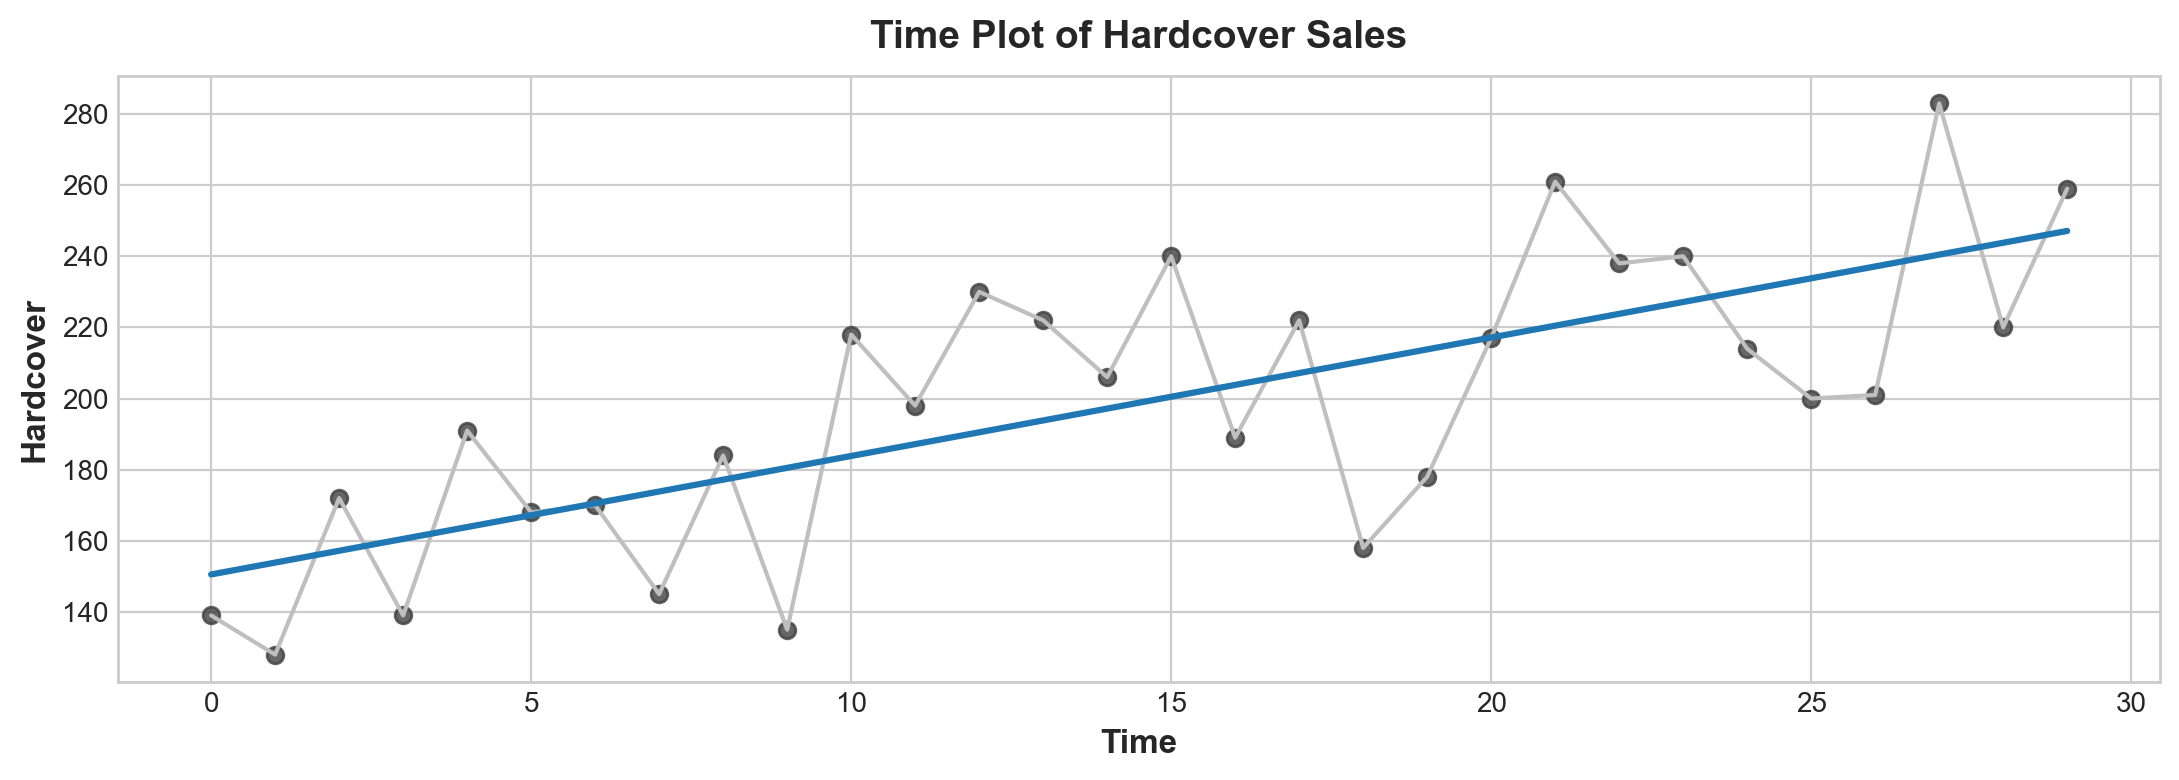

In [45]:
fig, ax = plt.subplots(figsize=(11, 4))
ax.plot('Time', 'Hardcover', data=df2, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=df2, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales');

In [46]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

C:\Users\adams\AppData\Local\Temp\ipykernel_9740\2574797347.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [47]:
df['Date'] = df['Date'].dt.to_period("D")

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype    
---  ------     --------------  -----    
 0   Date       30 non-null     period[D]
 1   Hardcover  30 non-null     int64    
dtypes: int64(1), period[D](1)
memory usage: 612.0 bytes


In [51]:
df = df.set_index(['Date']).sort_index()

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 30 entries, 2000-04-01 to 2000-04-30
Freq: D
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Hardcover  30 non-null     int64
dtypes: int64(1)
memory usage: 480.0 bytes


In [55]:
moving_average = df.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)


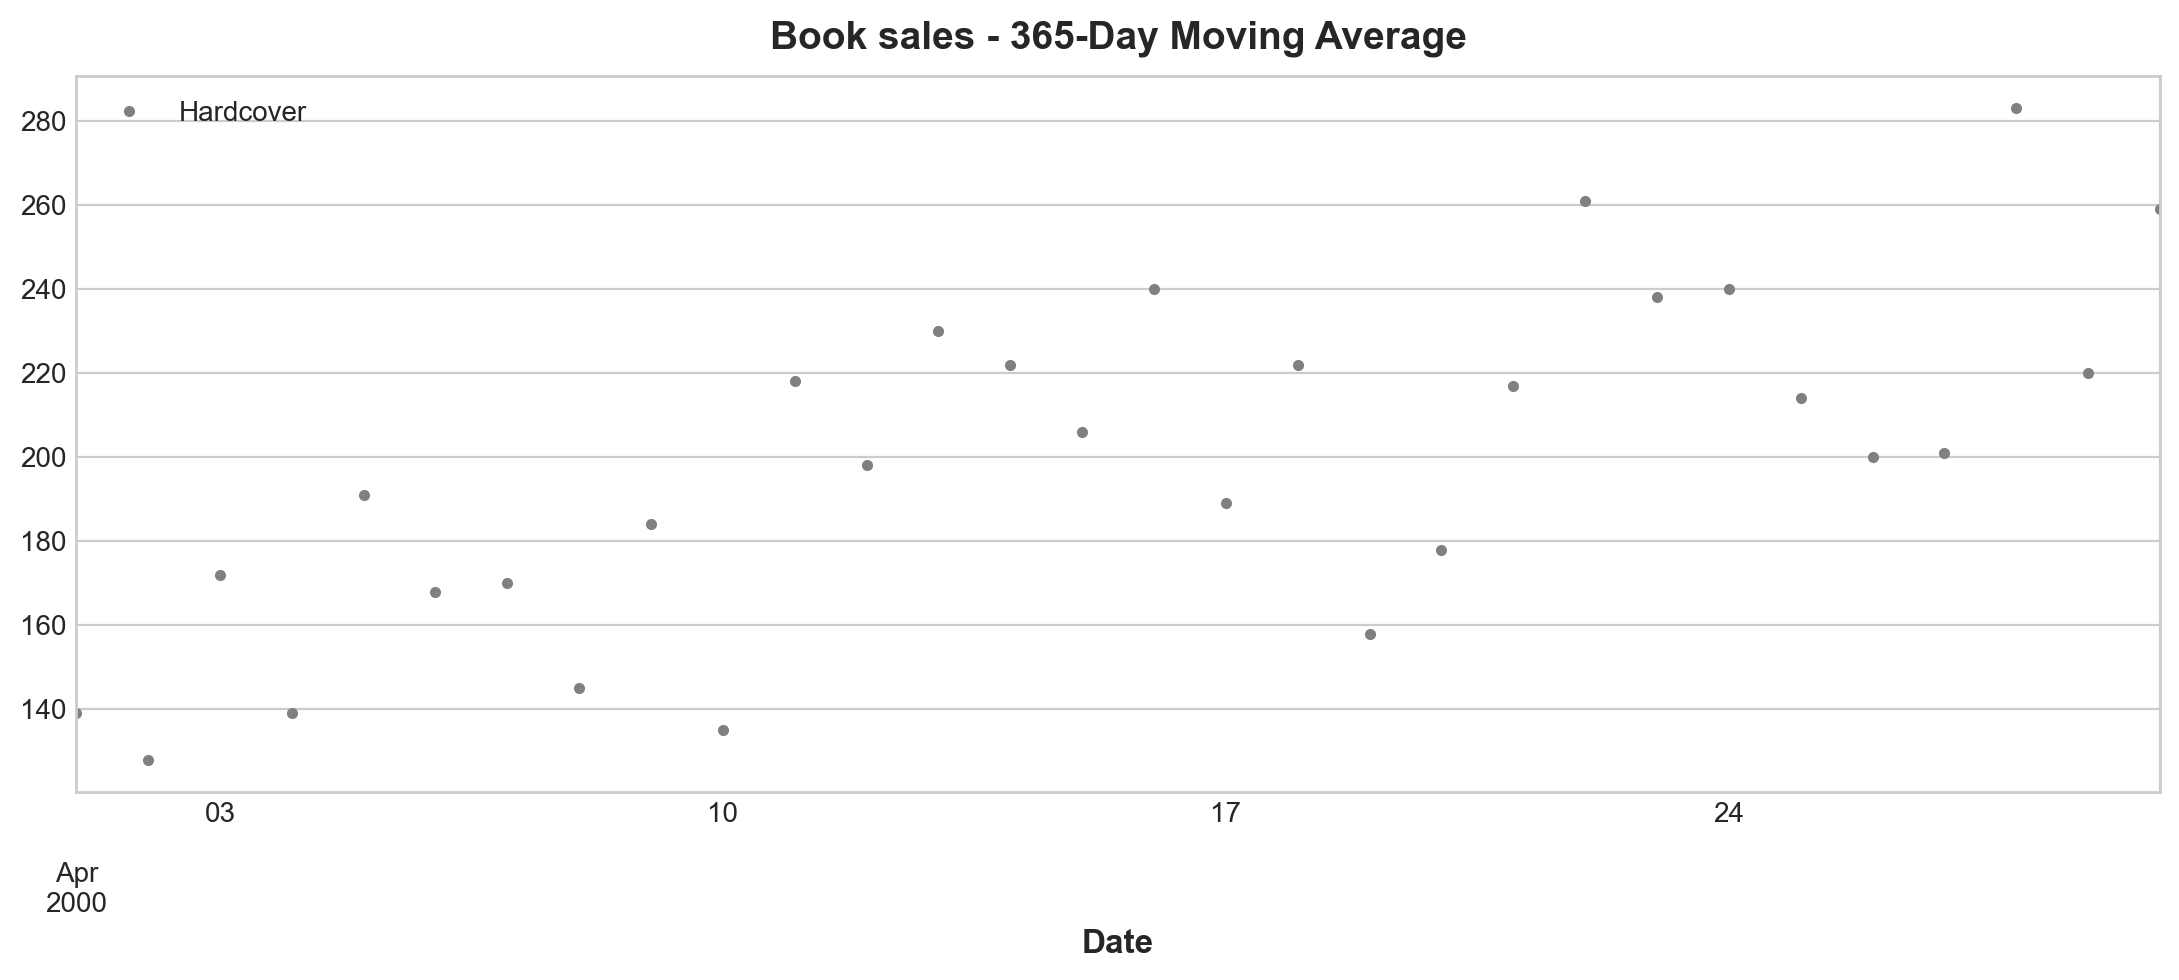

In [56]:
ax = df.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Book sales - 365-Day Moving Average", legend=False,
);

In [57]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=df.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
Date,,
2000-04-01,1.0,1.0
2000-04-02,1.0,2.0
2000-04-03,1.0,3.0
2000-04-04,1.0,4.0
2000-04-05,1.0,5.0


In [59]:
from sklearn.linear_model import LinearRegression

y = df["Hardcover"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

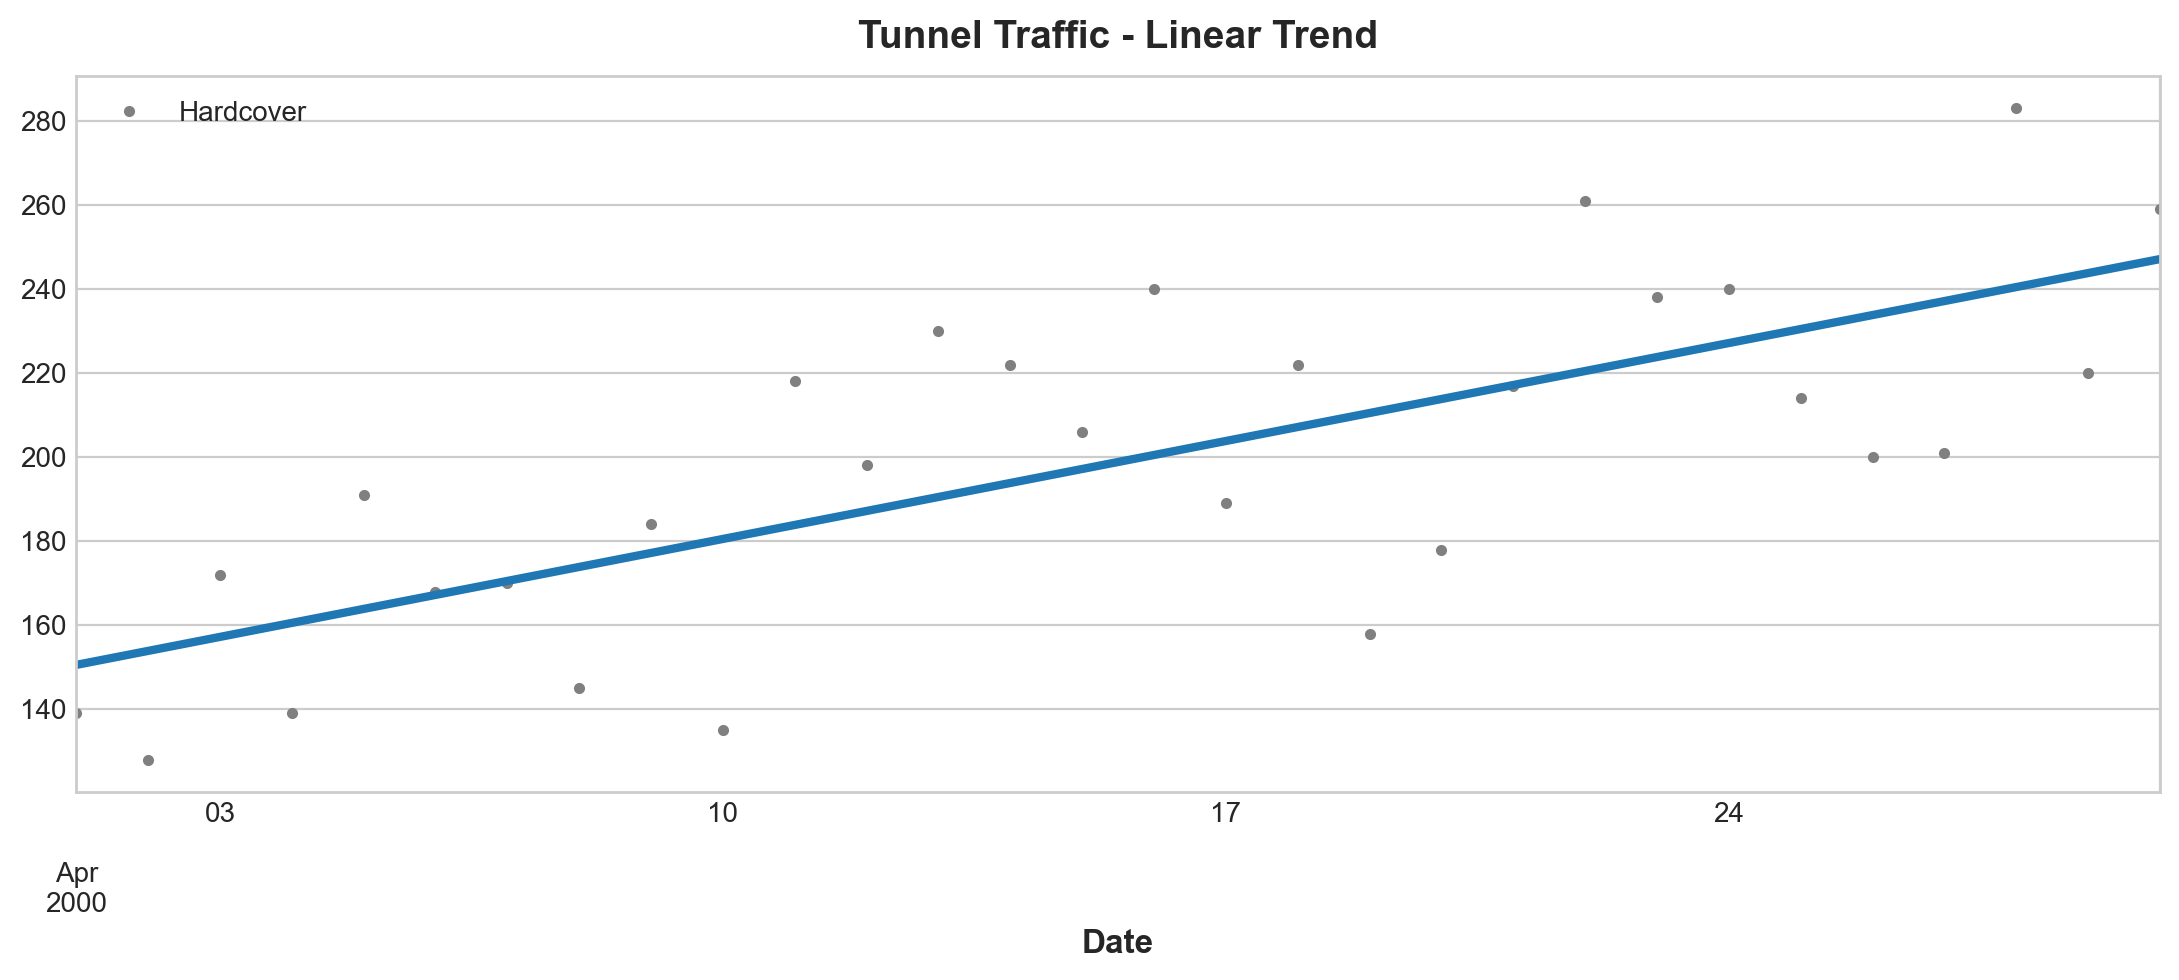

In [60]:
ax = df.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [71]:
X = dp.out_of_sample(steps=10)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2000-05-01    250.457471
2000-05-02    253.788061
2000-05-03    257.118650
2000-05-04    260.449240
2000-05-05    263.779829
Freq: D, dtype: float64

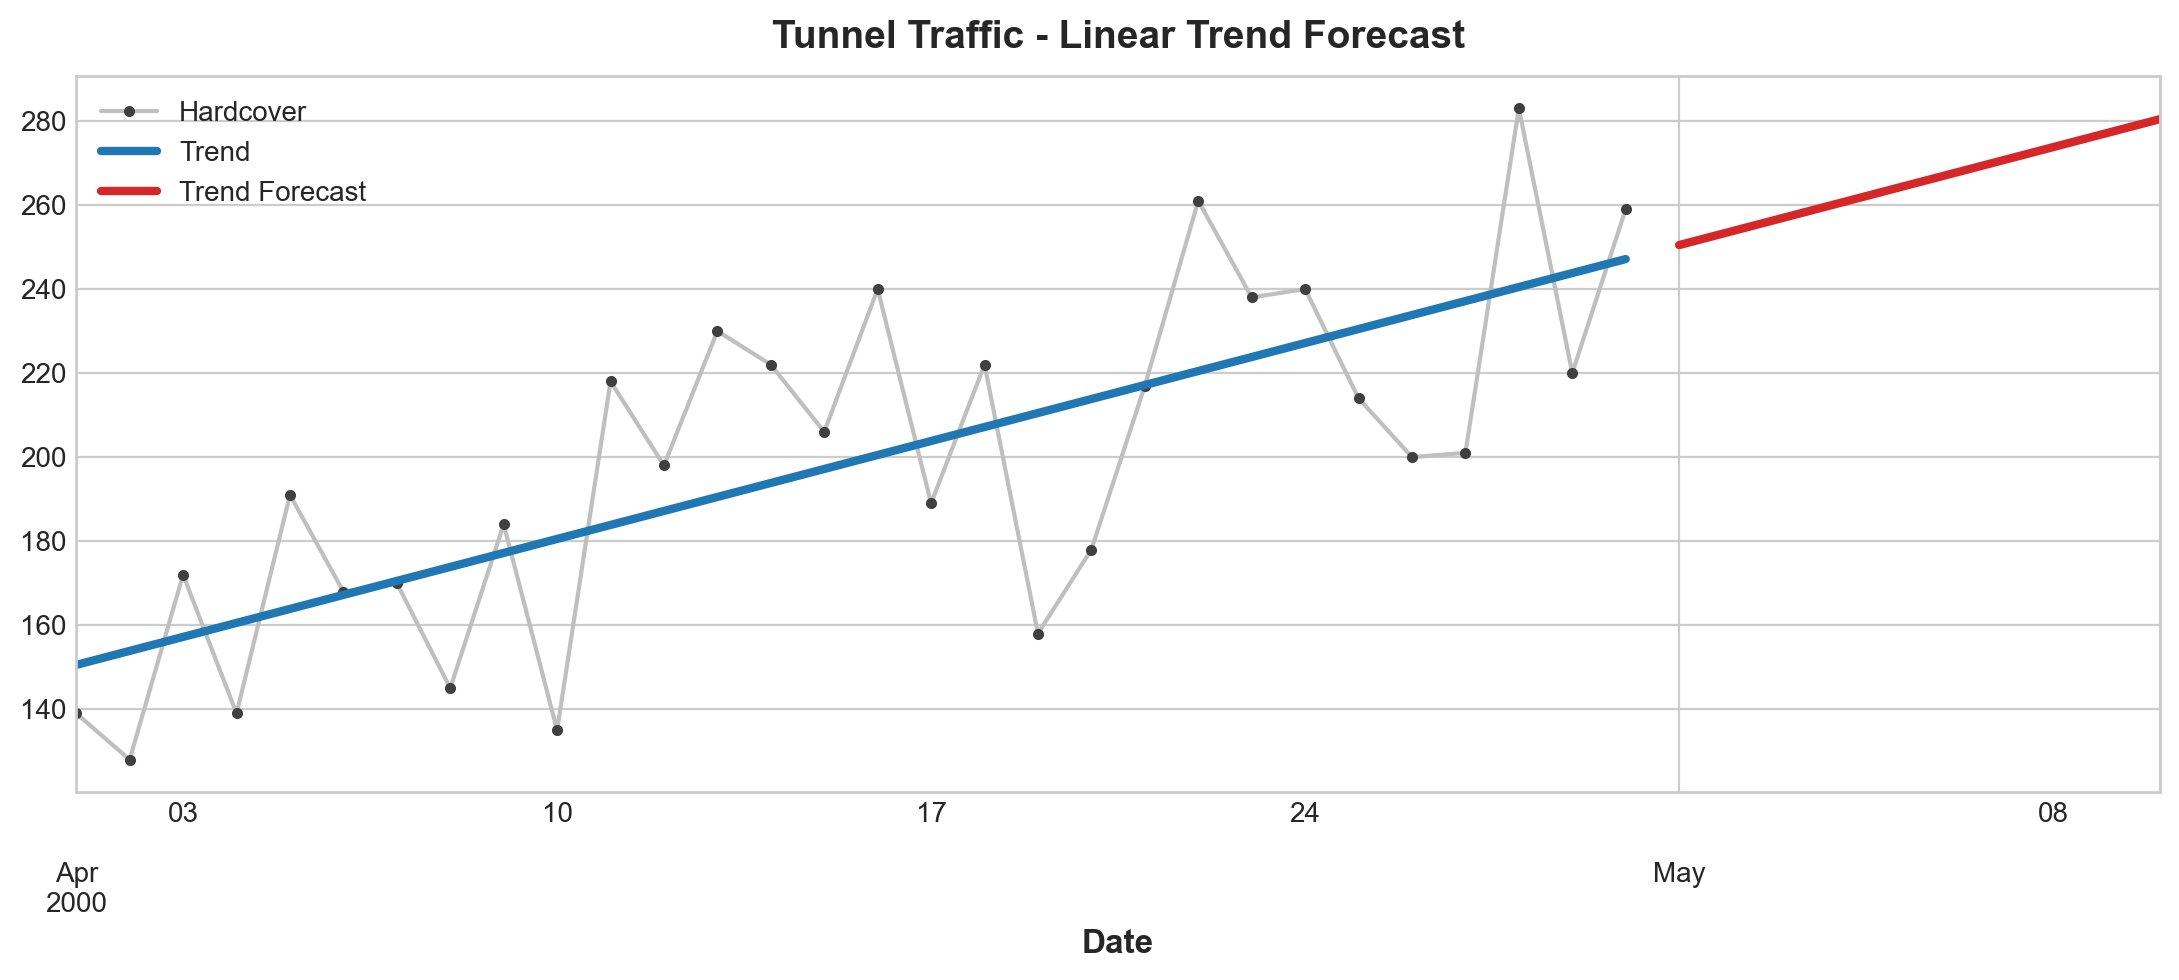

In [72]:
ax = df.plot(title="Book sale - Linear Trend Forecast", **plot_params)
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

In [75]:
df_s = pd.DataFrame(df)

In [78]:
df_s = df_s.reset_index()

In [79]:
df_s['week_day'] = df_s['Date'].dt.weekday
df_s['month_day'] = df_s['Date'].dt.day
df_s['year_day'] = df_s['Date'].dt.day_of_year

In [81]:
df_s['time'] = np.arange(len(df_s))

In [82]:
df_s.head(3)

,Date,Hardcover,week_day,month_day,year_day,time
0,2000-04-01,139,5,1,92,0
1,2000-04-02,128,6,2,93,1
2,2000-04-03,172,0,3,94,2


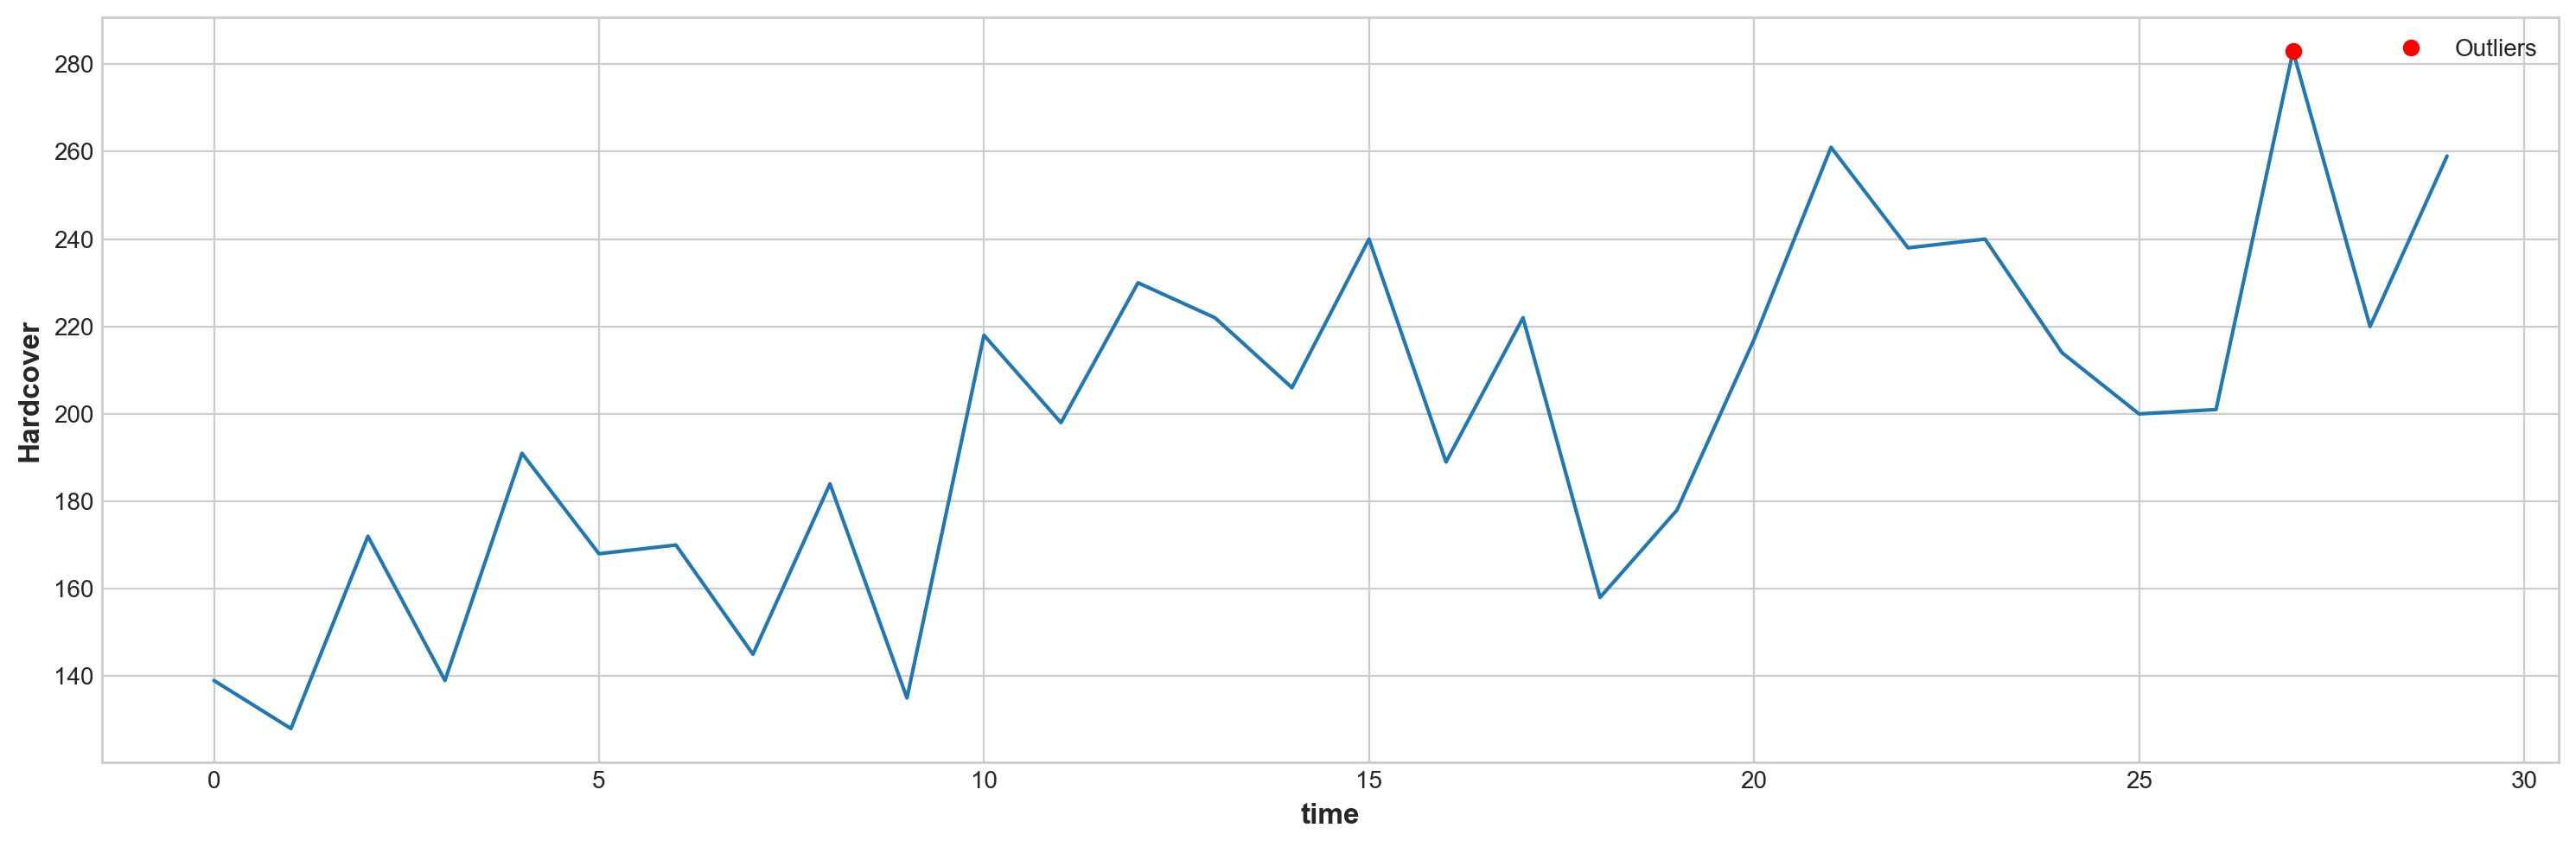

In [86]:
# Calculating the mean and standard deviation of the sales
mean_sales = df_s['Hardcover'].mean()
std_sales = df_s['Hardcover'].std()

# Seting a threshold for outliers (e.g., 2 standard deviations from the mean)
outlier_threshold = 2

# Identifying outliers
outliers = df_s[(df_s['Hardcover'] > mean_sales + outlier_threshold * std_sales) |
                         (df_s['Hardcover'] < mean_sales - outlier_threshold * std_sales)]

# Creating a figure with a primary y-axis for sales
fig, ax1 = plt.subplots(figsize=(15, 5))
sns.lineplot(x='time', y='Hardcover', data=df_s, ax=ax1)
plt.errorbar(x=outliers['time'], y=outliers['Hardcover'], fmt='ro', label='Outliers')
ax1.legend()


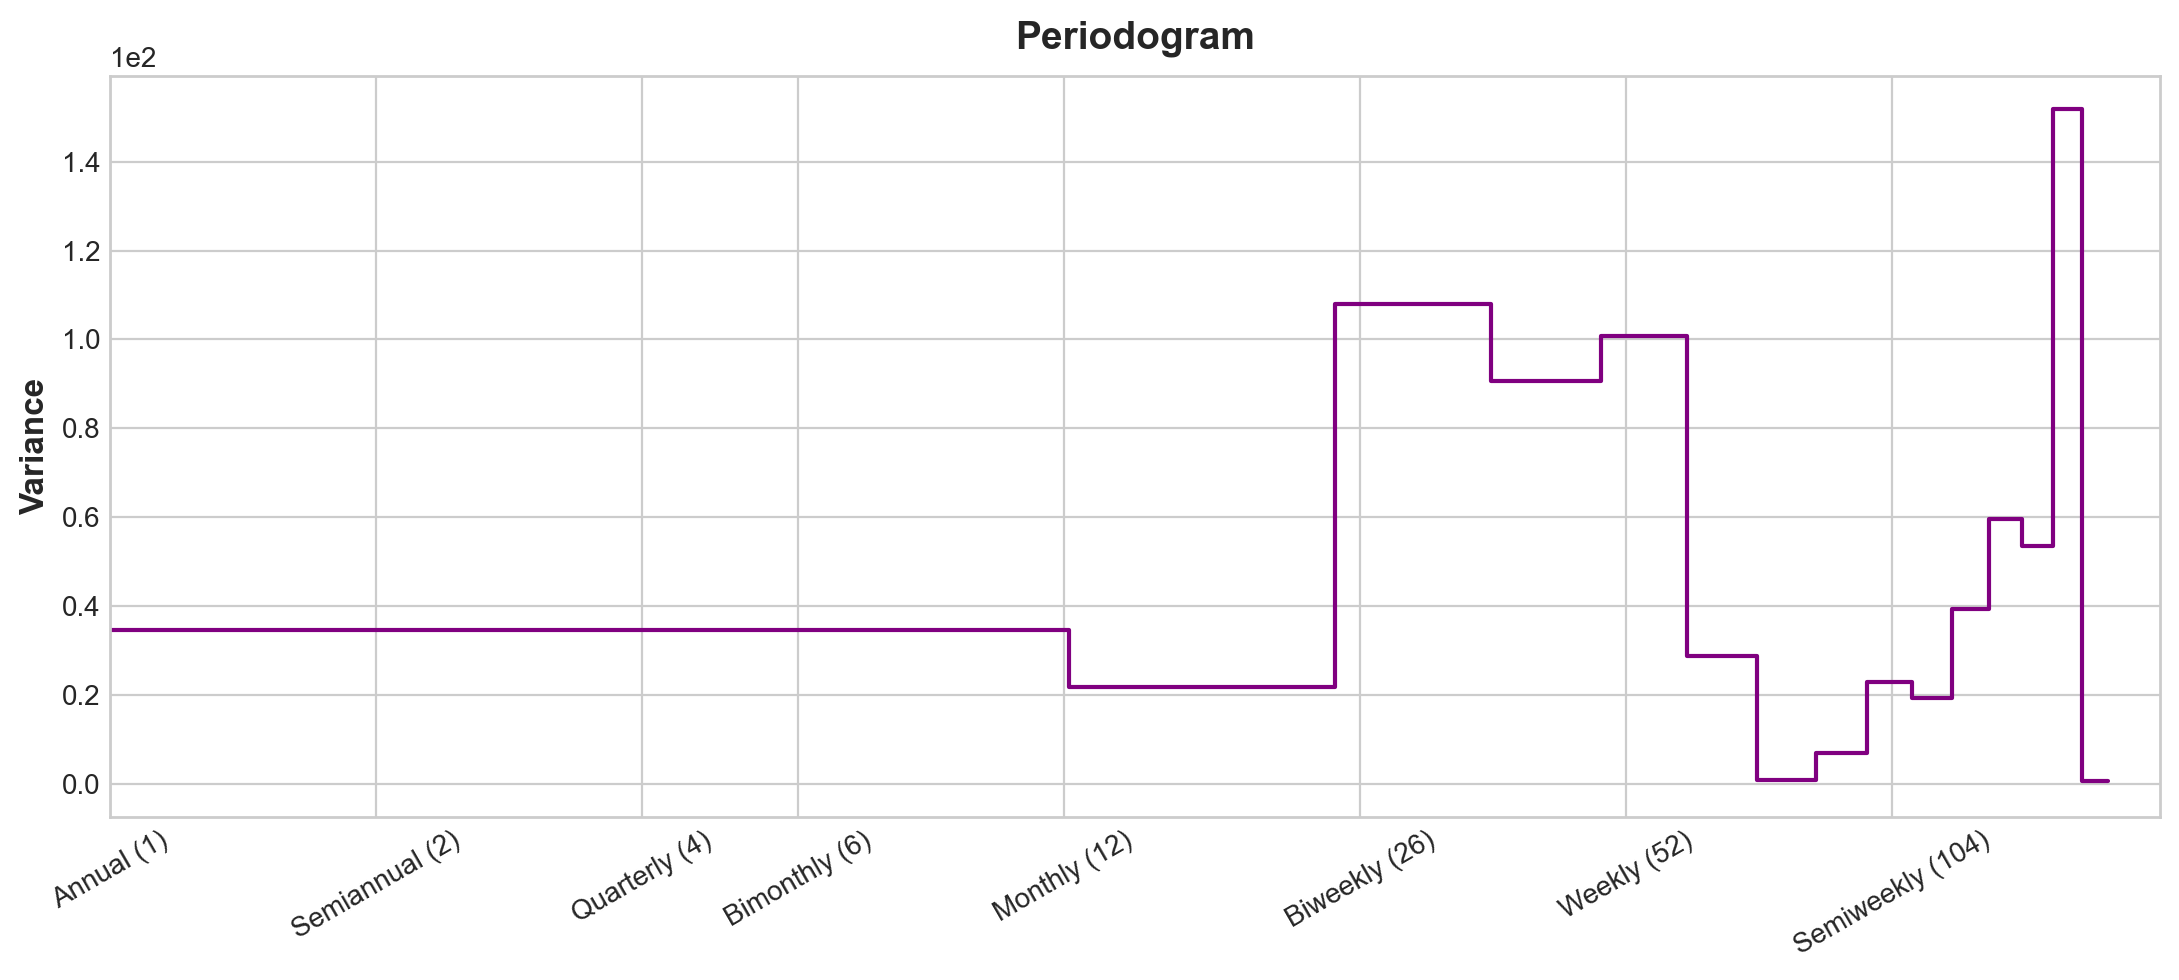

In [87]:
# Here we defined a peiodogram plot that tells us the type of seasonality in our data
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram

    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )

    if ax is None:
        _, ax = plt.subplots()

    ax.step(frequencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")

    return ax

# Astore_sales_suming your sales data is in a DataFrame named 'sales_data' with a datetime index
# Adjust this according to your actual data structure
sales_data = pd.DataFrame({'sales': np.random.rand(365)}, index=pd.date_range('2022-01-01', '2022-12-31', freq='D'))

# Use the custom plot_periodogram function
plot_periodogram(df_s['Hardcover'])
plt.show()


C:\Users\adams\AppData\Local\Temp\ipykernel_9740\874592137.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_s, x='week_day',marker='o', y='Hardcover', ci=None, color='blue')


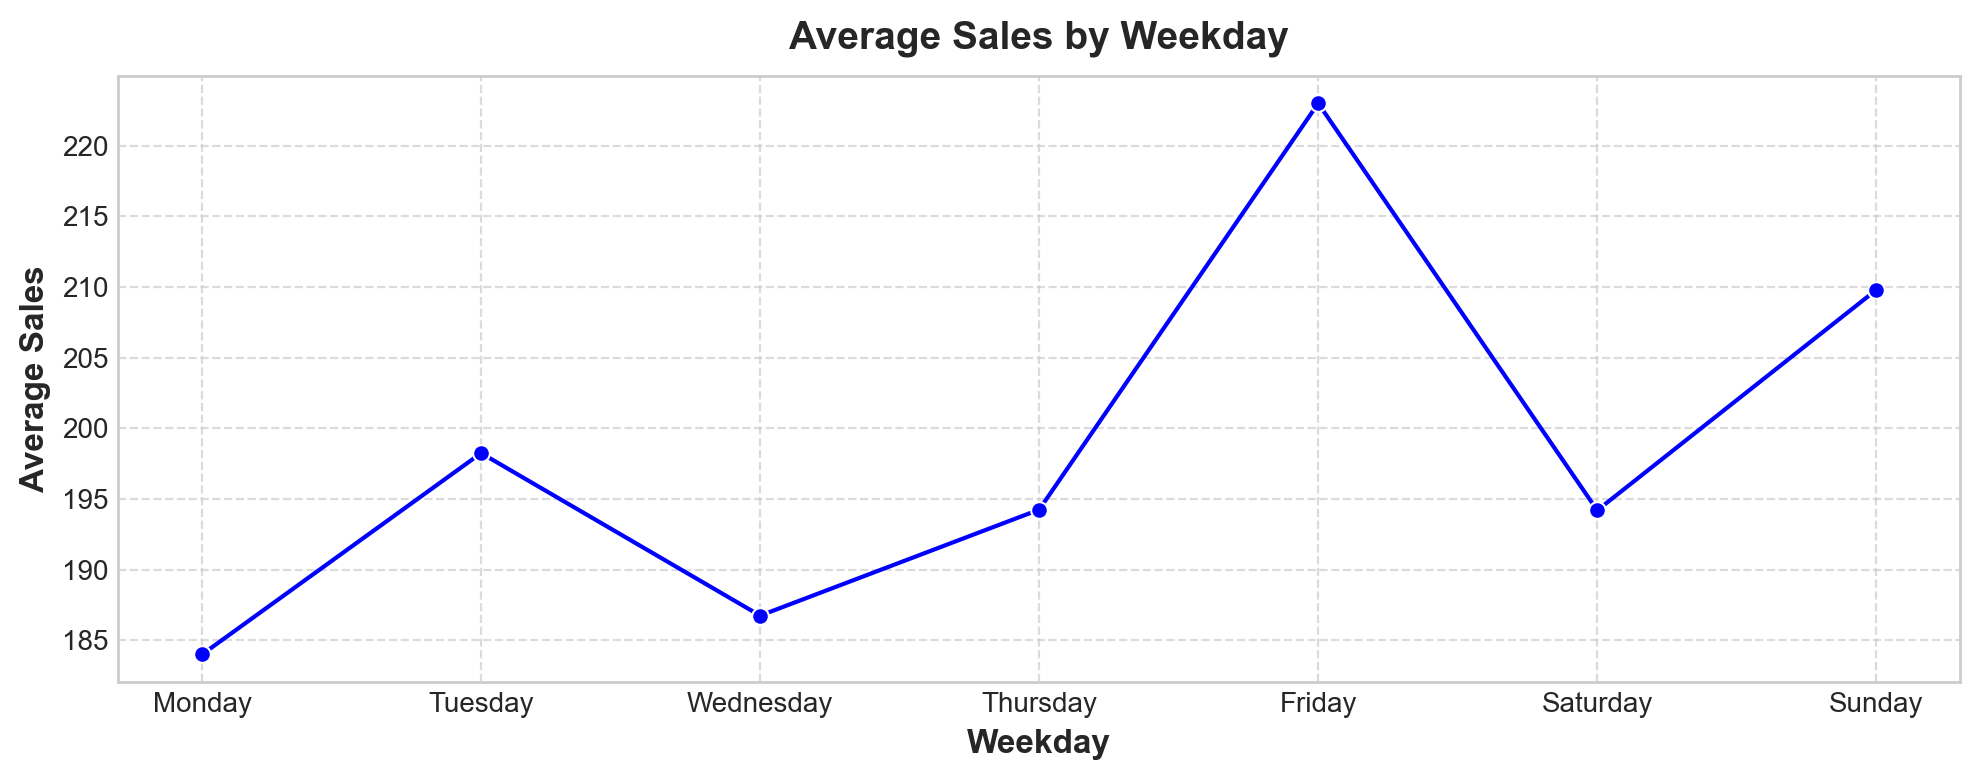

In [88]:
# Astore_sales_suming store_sales_s has a 'week_day' column
plt.figure(figsize=(10, 4))

# Plot using seaborn and matplotlib
sns.lineplot(data=df_s, x='week_day',marker='o', y='Hardcover', ci=None, color='blue')

# Adding title and labels
plt.title('Average Sales by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Average Sales')

# Customizing the x-axis labels
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks(ticks=range(7), labels=weekday_names)

# Adding grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

C:\Users\adams\AppData\Local\Temp\ipykernel_9740\570727029.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_s, x='month_day',marker='o', y='Hardcover', ci=None, color='blue')


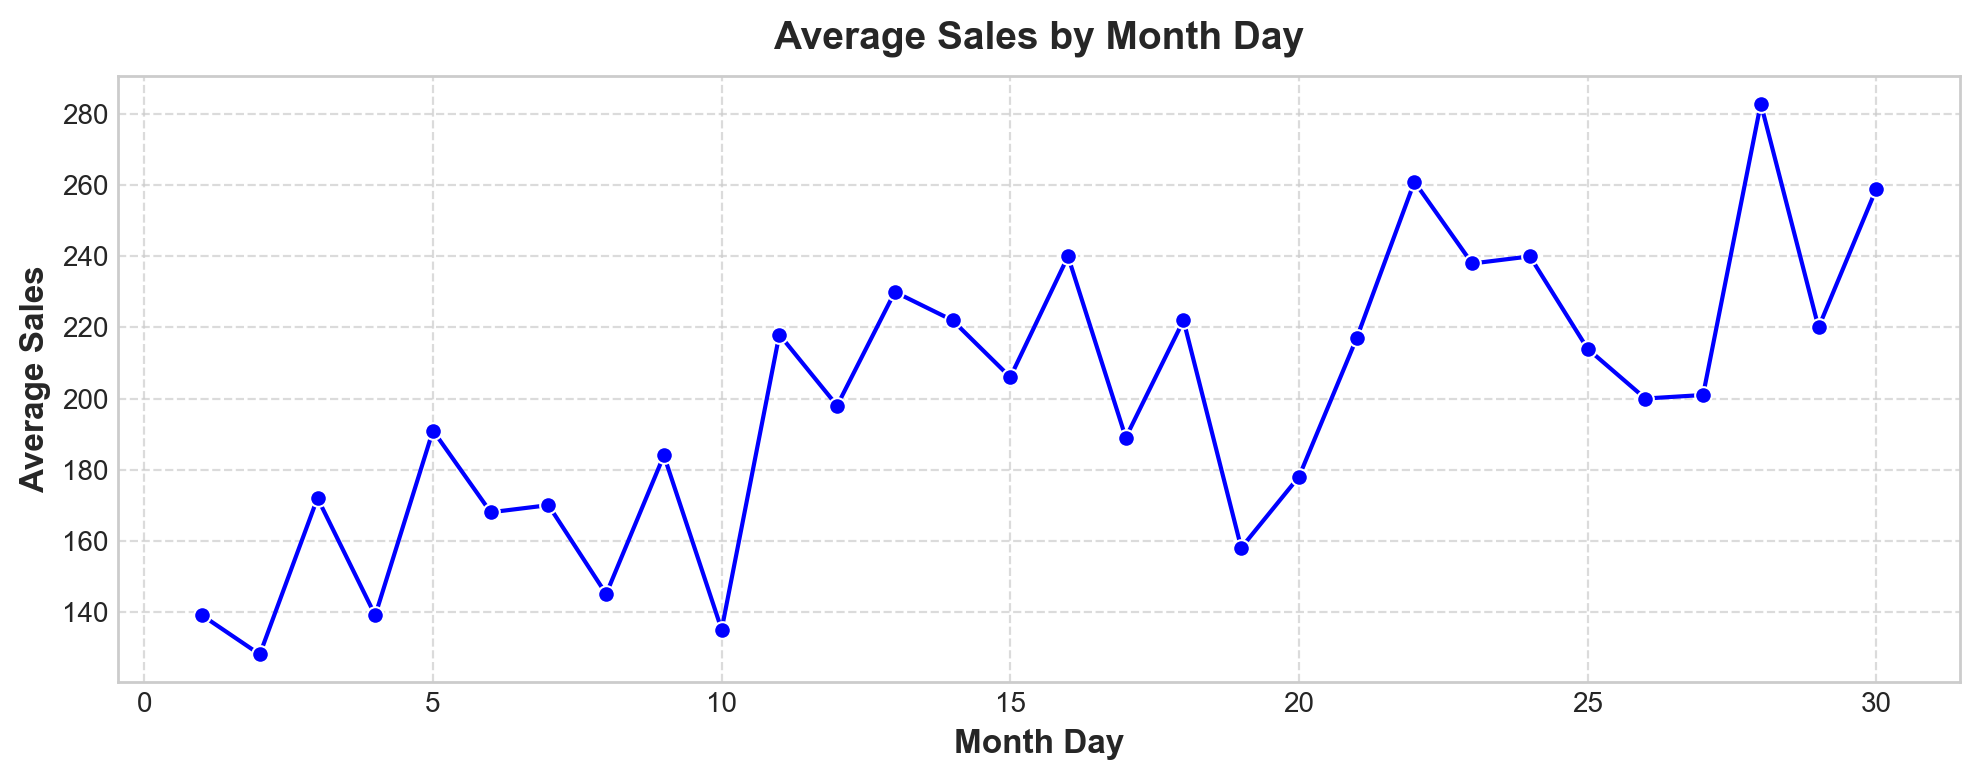

In [90]:
# Checking the monthly seasonality in the data using the month_day column

# Astore_sales_suming store_sales_s has a 'month_day' column
plt.figure(figsize=(10, 4))

# Plot using seaborn and matplotlib
sns.lineplot(data=df_s, x='month_day',marker='o', y='Hardcover', ci=None, color='blue')

# Adding title and labels
plt.title('Average Sales by Month Day')
plt.xlabel('Month Day')
plt.ylabel('Average Sales')

# Customizing the x-axis labels
# plt.xticks(rotation=45, ha='right')  # Adjust rotation for better readability

# Adding grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
# plt.tight_layout()
plt.show()

C:\Users\adams\AppData\Local\Temp\ipykernel_9740\2387323795.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_s, x='year_day', y='Hardcover', ci=None, color='blue', label='Average Sales')


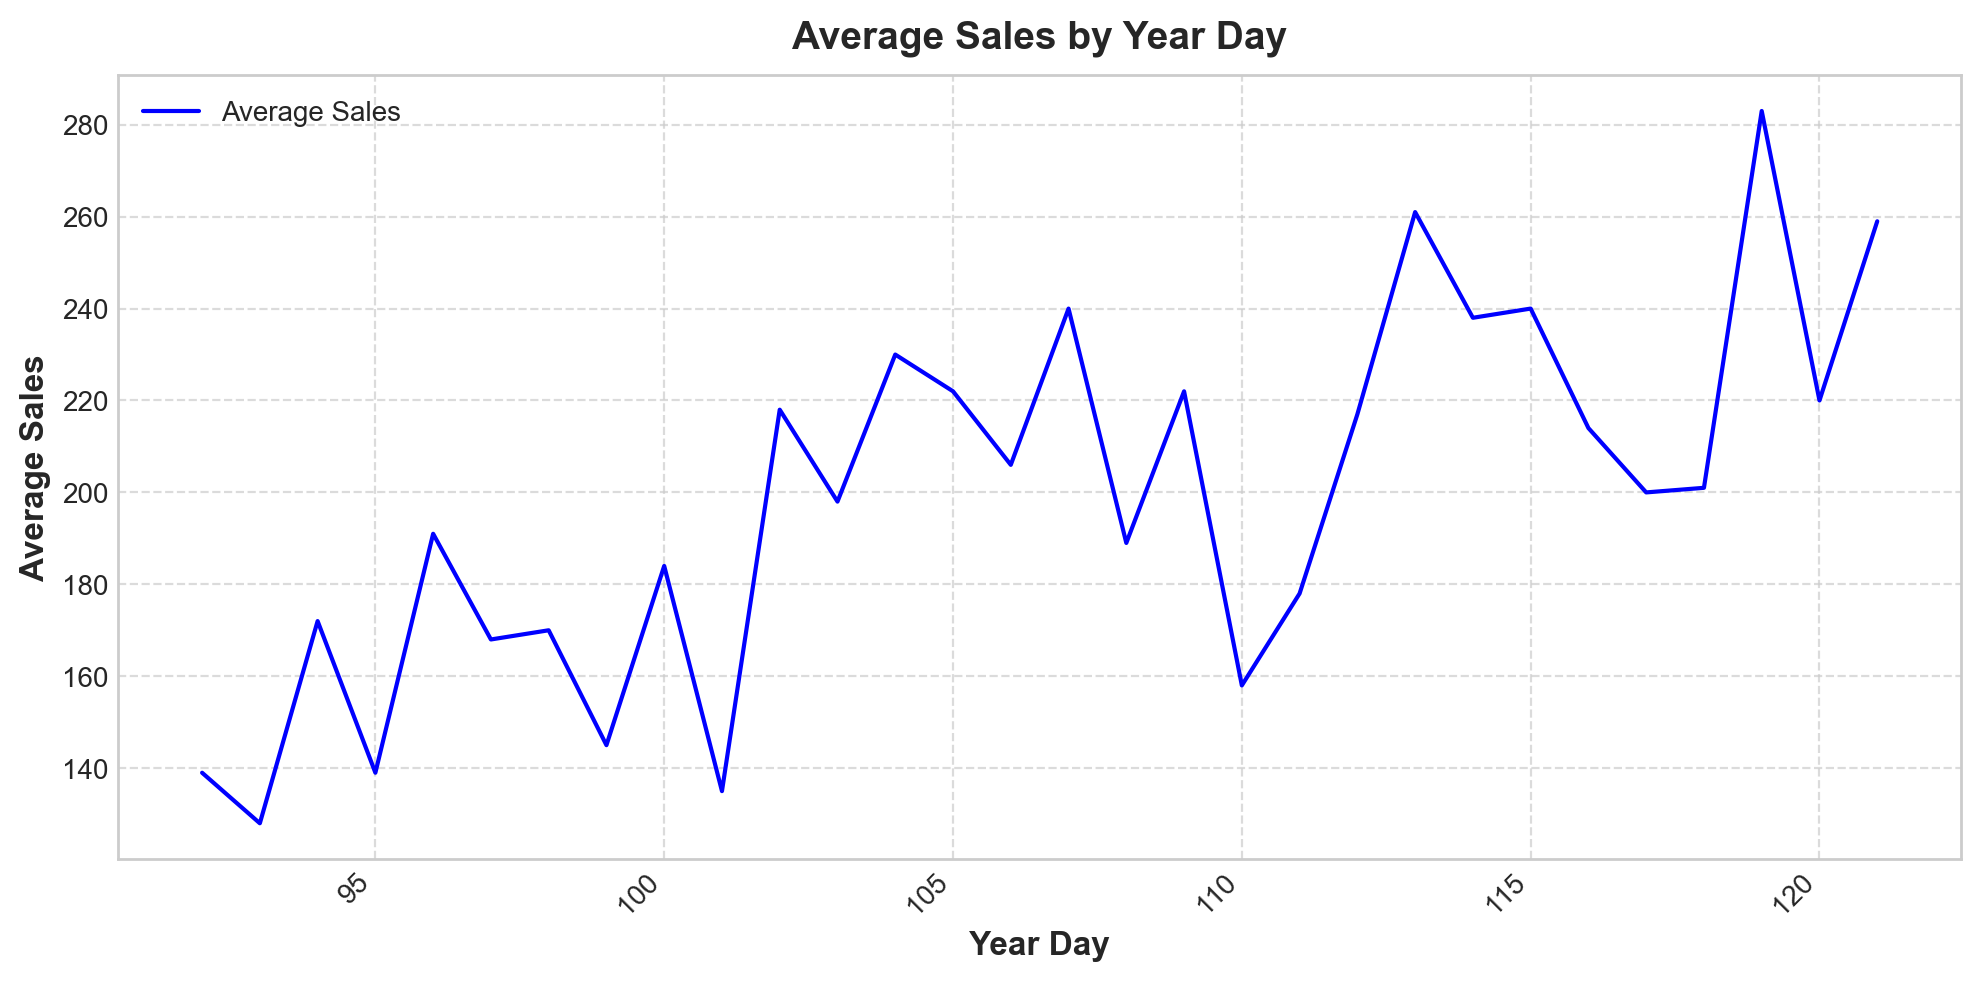

In [91]:
# Astore_sales_suming store_sales_s has a 'year_day' column
plt.figure(figsize=(10, 5))

# Plot using seaborn and matplotlib
sns.lineplot(data=df_s, x='year_day', y='Hardcover', ci=None, color='blue', label='Average Sales')

# Adding title and labels
plt.title('Average Sales by Year Day')
plt.xlabel('Year Day')
plt.ylabel('Average Sales')

# Customizing the x-axis labels
plt.xticks(rotation=45, ha='right')  # Adjust rotation for better readability

# Adding grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()